# Imports

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Image Pre-Processing

In [ ]:
# <<<<< NOT USED >>>>>
# Image preprocessing
# I have included this code here in case it was required but currently not using.
# This code allows us to use a smaller number of images and create multiple versions of the same image.

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

img = load_img('/content/drive/MyDrive/Datasets/Leaf_Data/training/diseased/0012_0001.JPG')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='/content/drive/MyDrive/Datasets/Leaf_Data/training/preprocess', save_prefix='leaf', save_format='jpg'):
    i += 1
    if i > 20: # Generates 20 variations of the same image
        break

# Load and Pre-Process Image Dataset

In [ ]:
# <<<<< NOT USED >>>>>
# Load and preprocess the dataset
# This was my starting code using flow_from_directory and initial image target size of (128, 128)
# Images are being pulled from same pool and ImageDataGenerator is doing a 80/20 split for training and validation
# flow_from_directory generates batches of augmented data

train_datagen = ImageDataGenerator(rescale=0.1, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/Datasets/leafdata/train',
    target_size=(128, 128),
    #color_mode='rgb',
    batch_size=32,
    class_mode='binary')

validation_generator = train_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/Datasets/leafdata/train',
    target_size=(128, 128),
    #color_mode='rgb',
    batch_size=32,
    class_mode='binary')


Found 3390 images belonging to 2 classes.
Found 3390 images belonging to 2 classes.


In [ ]:
# <<<<< NOT USED >>>>>
# Load and pre-process image datase
# Second attempt with image target size of (256, 256) but still using a smaller about of images 747 training, 186 validation

train_datagen = ImageDataGenerator(rescale=0.1, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/Datasets/Leaf_Data/training',
    target_size=(256, 256),
    #color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
#    '/content/drive/MyDrive/Datasets/Leaf_Data/validation',
    directory='/content/drive/MyDrive/Datasets/Leaf_Data/training',
    target_size=(256, 256),
    #color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    subset='validation')

Found 747 images belonging to 2 classes.
Found 186 images belonging to 2 classes.


------------------------------------------------> **currently using in run** <------------------------------------------------

In [2]:
# Load and pre-process image dataset
# We have split the data for training and validation into separate directories. Some lines have been commented
# Here I switched to using image_data_from_directory for image_preprocessing
# image_data_from_directory generates a tf.data.dataset from image files in a directory

train_directory = '/content/drive/MyDrive/Datasets/leafdata/t_train'
validation_directory = '/content/drive/MyDrive/Datasets/leafdata/t_valid'

train_generator = tf.keras.preprocessing.image_dataset_from_directory(
        train_directory,
        #validation_split=validation_split,
        #subset="training",
        seed=42,
        image_size=(224, 224),
        batch_size=32)

validation_generator = tf.keras.utils.image_dataset_from_directory(
        validation_directory,
        #validation_split=validation_split,
        #subset="validation",
        seed=42,
        image_size=(224, 224),
        batch_size=32)

# Configure dataset for better performance
# I will use buffered prefetching of images so the disk does not become a bottleneck
AUTOTUNE = tf.data.AUTOTUNE

train_generator = train_generator.cache().prefetch(buffer_size=AUTOTUNE)
validation_generator = validation_generator.cache().prefetch(buffer_size=AUTOTUNE)


Found 3390 files belonging to 2 classes.
Found 842 files belonging to 2 classes.


# Baseline model using 3-layer CNN model

------------------------------------------------> **currently using in run** <------------------------------------------------

In [4]:
# Our baseline model does a (1./255) rescaling to normalize every image into a uniform scale
# Rescaling also normalizes pixel values between [-1, 1] instead of [0, 255]
# The sequential model is made up of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each.
# The final layer (tf.keras.layers.Dense) is a fully connected layer with 128 units and activated by the ReLU function

basemodel =  tf.keras.Sequential([
      tf.keras.layers.Rescaling(1./255),
      tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(2)
    ])

# Compile model
basemodel.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])


In [6]:
# Train the model
history = basemodel.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)

Epoch 1/10
106/106 [==============================] - 873s 7s/step - loss: 0.6296 - accuracy: 0.6251 - val_loss: 0.5938 - val_accuracy: 0.7209
Epoch 2/10
106/106 [==============================] - 4s 40ms/step - loss: 0.4814 - accuracy: 0.7705 - val_loss: 0.5210 - val_accuracy: 0.7518
Epoch 3/10
106/106 [==============================] - 4s 41ms/step - loss: 0.3395 - accuracy: 0.8522 - val_loss: 0.4800 - val_accuracy: 0.7648
Epoch 4/10
106/106 [==============================] - 4s 40ms/step - loss: 0.2161 - accuracy: 0.9112 - val_loss: 0.5278 - val_accuracy: 0.7660
Epoch 5/10
106/106 [==============================] - 4s 40ms/step - loss: 0.1820 - accuracy: 0.9277 - val_loss: 0.6565 - val_accuracy: 0.7530
Epoch 6/10
106/106 [==============================] - 4s 40ms/step - loss: 0.1177 - accuracy: 0.9546 - val_loss: 0.7016 - val_accuracy: 0.7850
Epoch 7/10
106/106 [==============================] - 4s 39ms/step - loss: 0.0817 - accuracy: 0.9705 - val_loss: 0.7931 - val_accuracy: 0.7708

In [7]:
# Evaluate the model
test_loss, test_acc = basemodel.evaluate(validation_generator, verbose=2)
print("\nTest accuracy:", test_acc)


27/27 - 0s - loss: 0.8486 - accuracy: 0.7791 - 353ms/epoch - 13ms/step

Test accuracy: 0.7790973782539368


# Final Model

In [ ]:
# Final model
# Model using random image augmentation and dropout
# Rotation, translation, flip and contrast are randomly adjusted on images.

with tf.device('/CPU:0'):
    img_augmentation = tf.keras.models.Sequential([
        tf.keras.layers.RandomRotation(factor=0.1),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomContrast(factor=0.1)
    ])


# Create CNN model, buffed with data augmentation (random) and dropout.

model = tf.keras.Sequential([
    img_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.1),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.1),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.1),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator
)

Epoch 1/40
106/106 [==============================] - 388s 3s/step - loss: 0.6898 - accuracy: 0.5372 - val_loss: 0.6408 - val_accuracy: 0.5914
Epoch 2/40
106/106 [==============================] - 8s 76ms/step - loss: 0.6545 - accuracy: 0.6260 - val_loss: 0.6007 - val_accuracy: 0.6948
Epoch 3/40
106/106 [==============================] - 8s 74ms/step - loss: 0.6238 - accuracy: 0.6743 - val_loss: 0.5664 - val_accuracy: 0.7458
Epoch 4/40
106/106 [==============================] - 8s 74ms/step - loss: 0.5996 - accuracy: 0.6897 - val_loss: 0.5204 - val_accuracy: 0.7862
Epoch 5/40
106/106 [==============================] - 8s 75ms/step - loss: 0.5322 - accuracy: 0.7345 - val_loss: 0.4078 - val_accuracy: 0.8254
Epoch 6/40
106/106 [==============================] - 8s 76ms/step - loss: 0.4678 - accuracy: 0.7844 - val_loss: 0.4145 - val_accuracy: 0.8254
Epoch 7/40
106/106 [==============================] - 8s 73ms/step - loss: 0.4349 - accuracy: 0.8012 - val_loss: 0.3856 - val_accuracy: 0.8325

# Plot and evaluate model

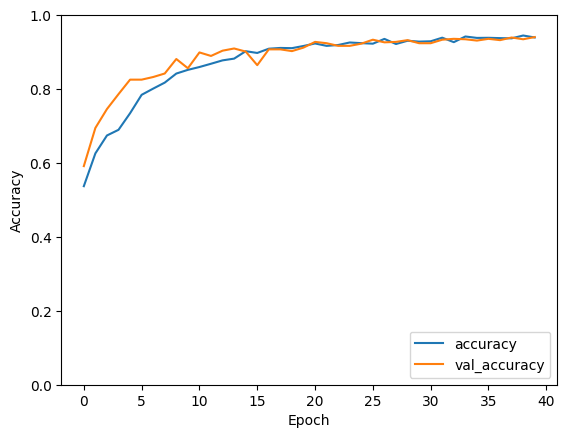

In [ ]:
# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(validation_generator, verbose=2)
print("\nTest accuracy:", test_acc)


27/27 - 0s - loss: 0.1804 - accuracy: 0.9406 - 407ms/epoch - 15ms/step

Test accuracy: 0.940617561340332


# Saving Model

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/Models/leaf_disease_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Predict on New Images

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

In [ ]:
model = load_model('/content/drive/MyDrive/Models/leaf_disease_classifier.h5')

In [ ]:
# Pre-process image

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    #img_array /= 255.0
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

In [ ]:
# Predict image

def predict_image(image_path):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    print(prediction)
    if prediction[0][0] < 0.5:
        return "Diseased"
    else:
        return "Healthy"

In [ ]:
result = predict_image('/content/t_0007_0061.JPG')
print(result)

1/1 [==============================] - 0s 22ms/step
[[-2.411489   1.6774503]]
Diseased


In [ ]:
result = predict_image('/content/t_0019_0065.JPG')
print(result)

1/1 [==============================] - 0s 20ms/step
[[-1.47126    1.3638656]]
Diseased


# Utilities

In [8]:
# Utility method to load an image from a given path.
def load_img(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


# Utility method to visualize an image.
def plot_img(img):
    plt.figure()
    plt.axis("off")
    plt.imshow(img)
    plt.show()


# Utility method to add the evaluation results of a model to the global results.
def add_result(results: dict, model: str, t_acc: float, t_loss: float, acc: float, f1: float, epochs: int):
    results['Model'].append(model)
    results['Training Acc.'].append(t_acc)
    results['Training Loss'].append(t_loss)
    results['Testing Acc.'].append(acc)
    results['Testing F1-score'].append(f1)
    results['Epochs/Depth'].append(epochs)
    return results

# Calculate the pixels distribution for a specific channel of a given image.
def get_channel_distrib(img, channel: str):
    channels = {'red': 0, 'green': 1, 'blue': 2}
    channel = img[:, :, channels[channel]]
    distrib_part, counts = np.unique(channel, return_counts=True)
    distrib_full = np.zeros(256)
    for i, count in zip(distrib_part, counts):
        distrib_full[i] = count
    return distrib_full

# Calculate the average pixels distributions of all 3 channels for all images of a given category (the 'pixels signature').
def get_pixels_signature(directory: str):
    red_channel_glob = np.zeros(256)
    blue_channel_glob = np.zeros(256)
    green_channel_glob = np.zeros(256)
    count_img = 0
    for img_name in tqdm(os.listdir(directory)):
        count_img += 1
        npy_array = load_img(os.path.join(directory, img_name))
        red_channel_glob += get_channel_distrib(npy_array, 'red')
        blue_channel_glob += get_channel_distrib(npy_array, 'blue')
        green_channel_glob += get_channel_distrib(npy_array, 'green')
    red_channel_glob /= count_img
    green_channel_glob /= count_img
    blue_channel_glob /= count_img
    return red_channel_glob, green_channel_glob, blue_channel_glob

# source: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# Plot pixels signature of a few categories as an example for illustration purpose.
def plot_class_pixels_signature(directory: str):
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    for category, ax in zip(os.listdir(directory)[:9], axs.flat):
        if os.path.isdir(os.path.join(directory, category)):
            r, g, b = get_pixels_signature(os.path.join(directory, category))
            x = np.arange(len(r))
            ax.set(xlabel='pixel value', ylabel='average count')
            ax.plot(x, r, color='red')
            ax.plot(x, g, color='green')
            ax.plot(x, b, color='blue')
            ax.set_title(f'{category}')
            ax.label_outer()
    plt.show()

100%|██████████| 456/456 [23:24<00:00,  3.08s/it]


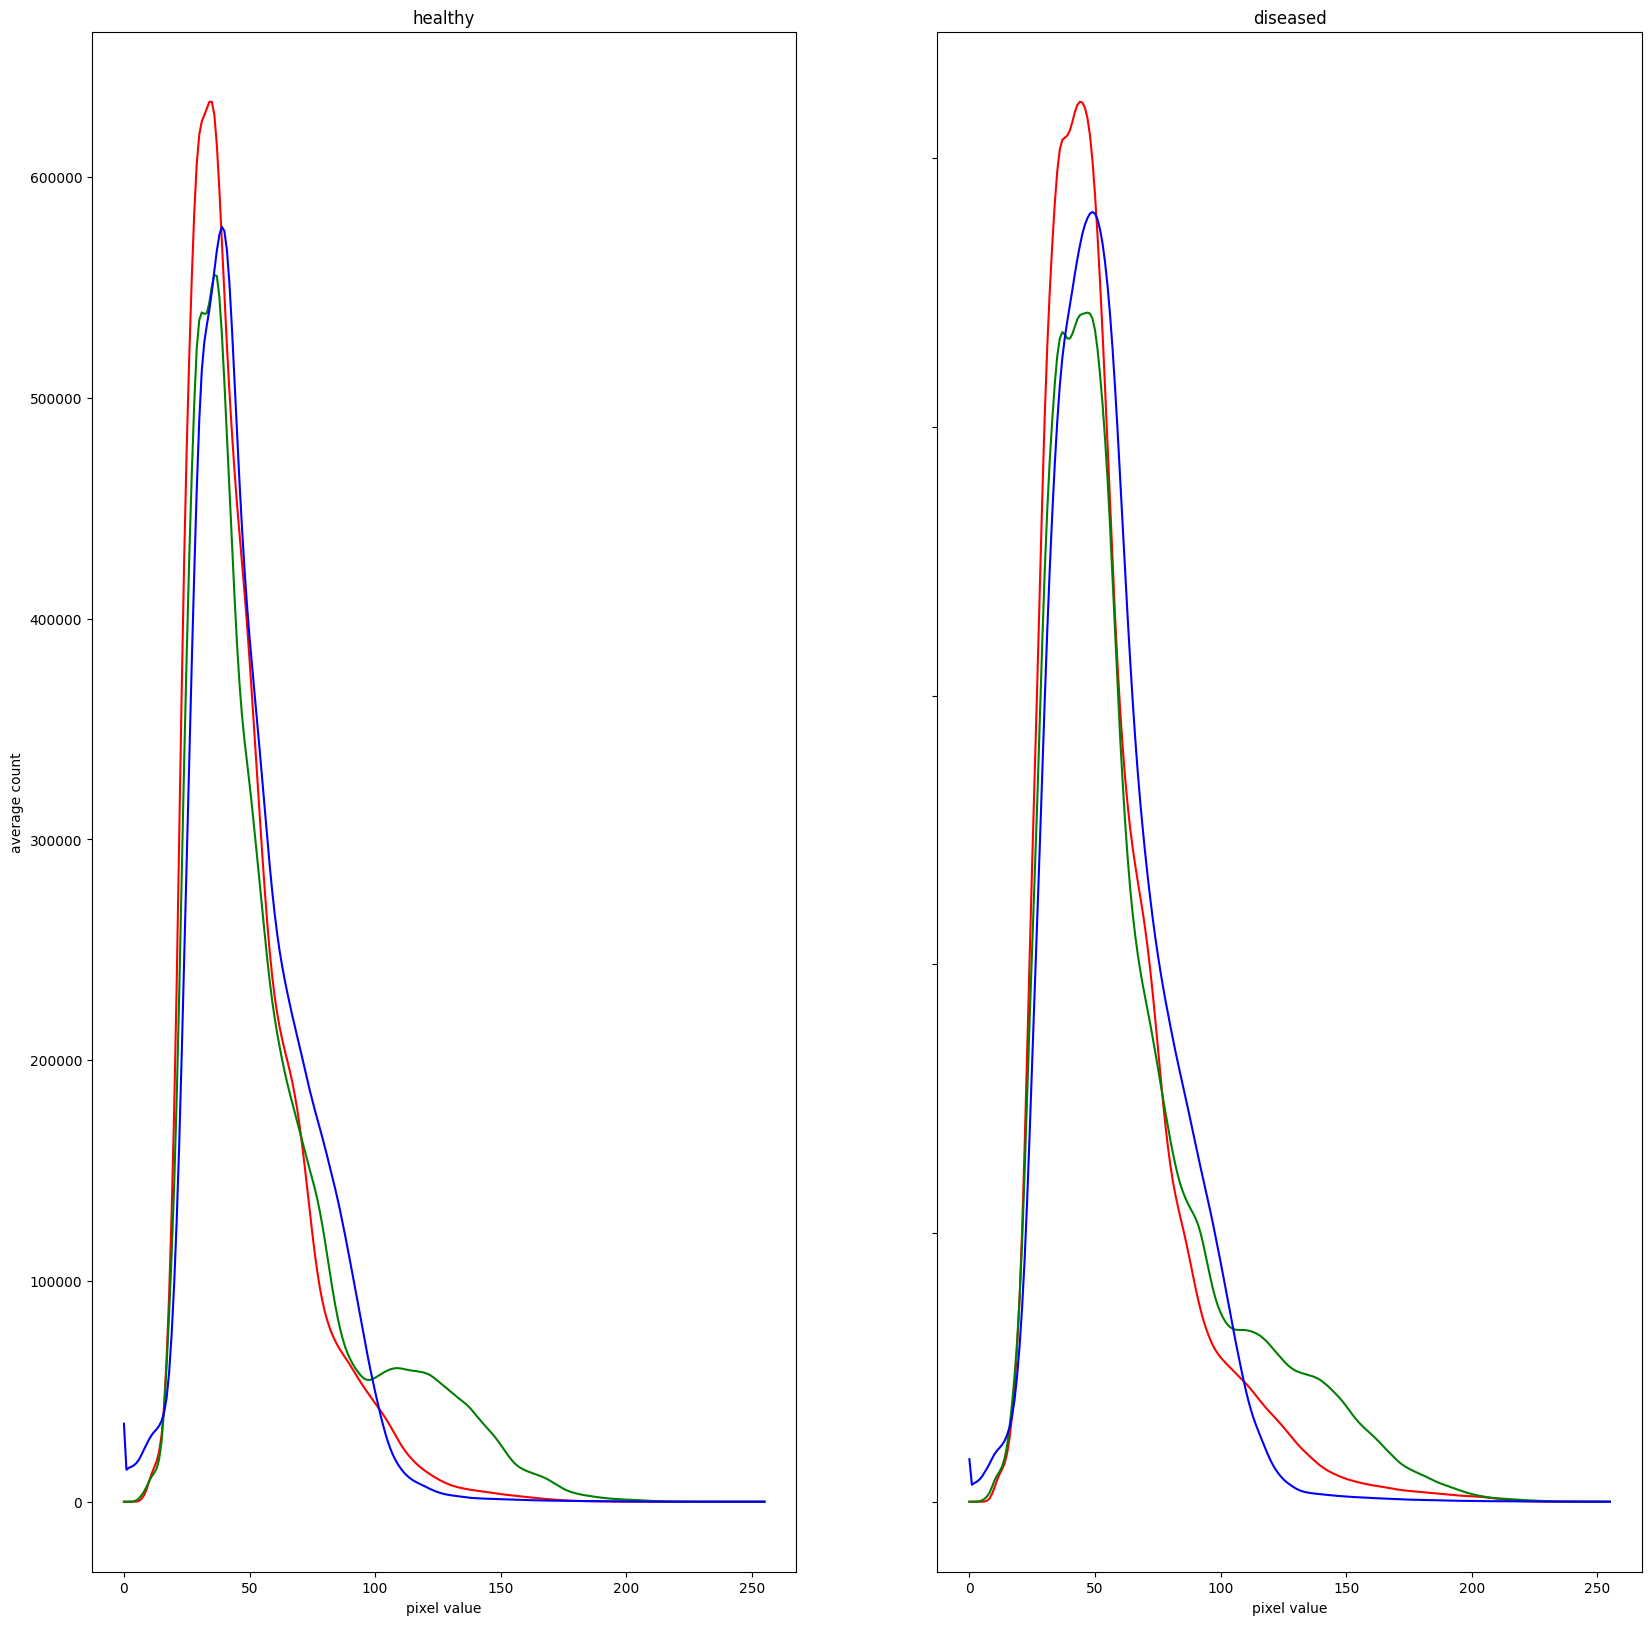

In [9]:
plot_class_pixels_signature('/content/drive/MyDrive/Datasets/Leaf_Data/training')

# Thresholding Images - Manual

In [ ]:
!pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.5 MB/s eta 0:00:00


In [ ]:
import glob

import imageio.v3 as iio
import ipympl
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
from pathlib import Path

%matplotlib widget

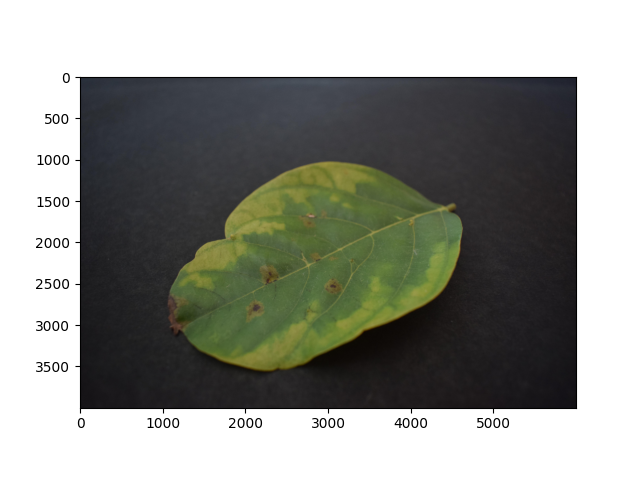

In [ ]:
# Load image
shapes01 = iio.imread(uri="/content/0019_0065.JPG")

fig, ax = plt.subplots()
ax.imshow(shapes01)

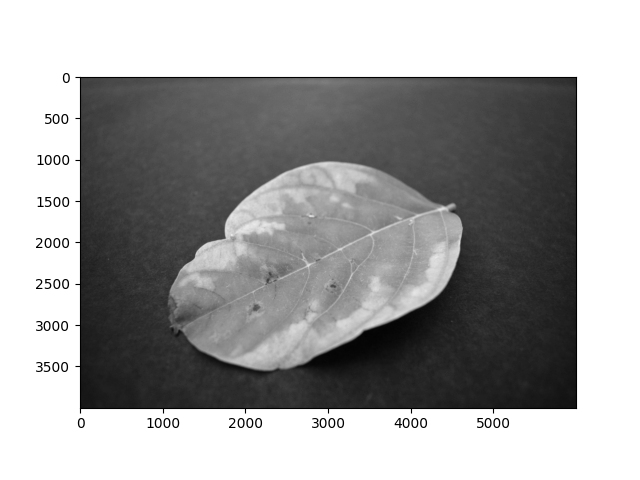

In [ ]:
# Convert the image to grayscale
gray_shapes = ski.color.rgb2gray(shapes01)

# Blur the image to denoise
blurred_shapes = ski.filters.gaussian(gray_shapes, sigma=1.0)

fig, ax = plt.subplots()
ax.imshow(blurred_shapes, cmap='gray')

(0.0, 1.0)

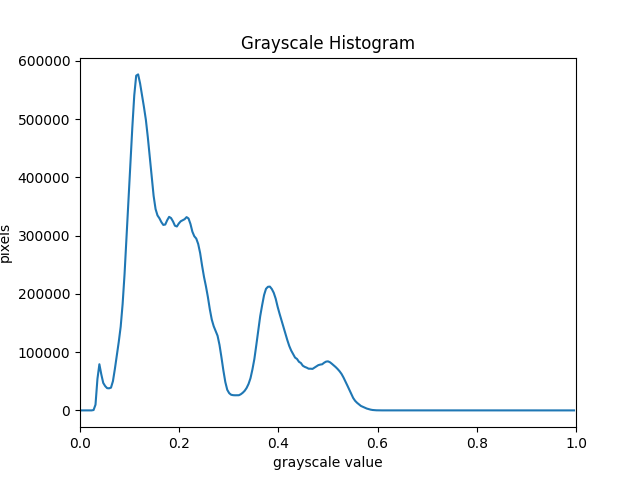

In [ ]:
# Create a histogram of the blurred grayscale image
histogram, bin_edges = np.histogram(blurred_shapes, bins=256, range=(0.0, 1.0))

# Plot the histogram
fig, ax = plt.subplots()
ax.plot(bin_edges[0:-1], histogram)
ax.set_title("Grayscale Histogram")
ax.set_xlabel("grayscale value")
ax.set_ylabel("pixels")
ax.set_xlim(0, 1.0)


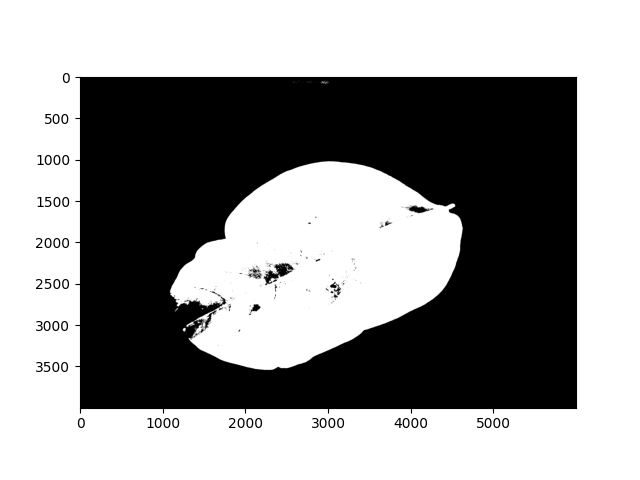

In [ ]:
# Create a mask based on the threshold
t = 0.33
binary_mask = blurred_shapes > t

fig, ax = plt.subplots()
ax.imshow(binary_mask, cmap='gray')

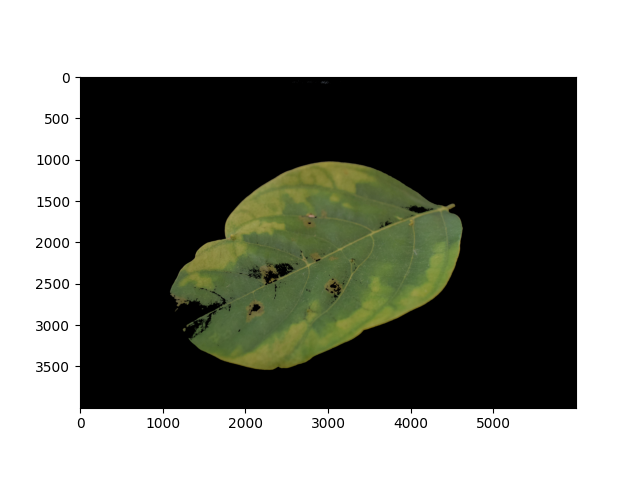

In [ ]:
# Use the binary_mask to select the "interesting" part of the image
selection = shapes01.copy()
selection[~binary_mask] = 0

fig, ax = plt.subplots()
ax.imshow(selection)

# Automatic thresholding

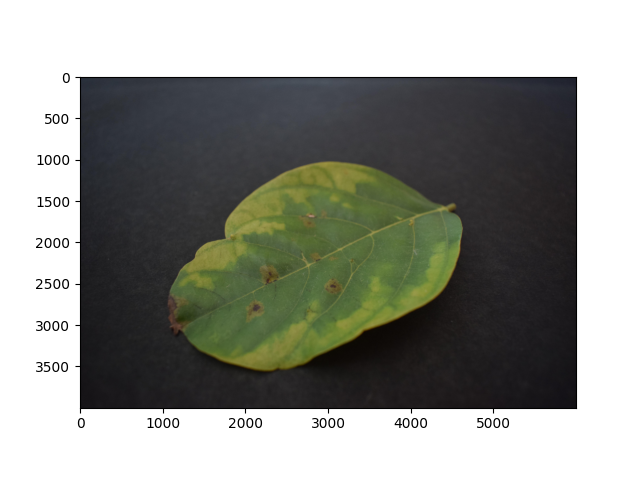

In [ ]:
leaf_det = iio.imread(uri="/content/0019_0065.JPG")

fig, ax = plt.subplots()
ax.imshow(leaf_det)

(0.0, 1.0)

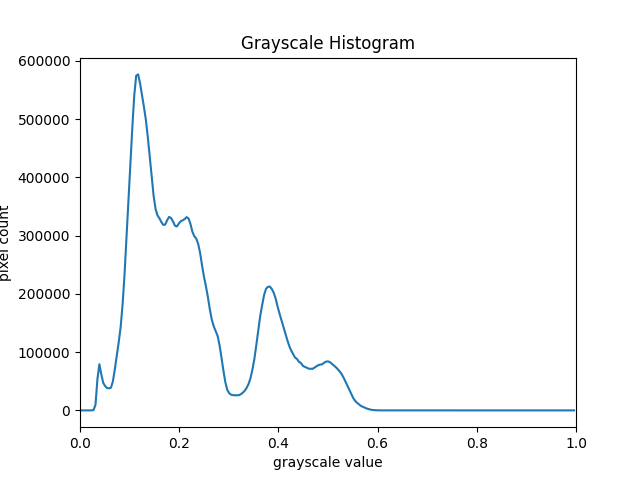

In [ ]:
# Convert the image to grayscale
gray_image = ski.color.rgb2gray(leaf_det)

# Blur the image to denoise
blurred_image = ski.filters.gaussian(gray_image, sigma=1.0)

# Show the histogram of the blurred image
histogram, bin_edges = np.histogram(blurred_image, bins=256, range=(0.0, 1.0))
fig, ax = plt.subplots()
ax.plot(bin_edges[0:-1], histogram)
ax.set_title("Grayscale Histogram")
ax.set_xlabel("grayscale value")
ax.set_ylabel("pixel count")
ax.set_xlim(0, 1.0)


In [ ]:
# Perform automatic thresholding
t = ski.filters.threshold_otsu(blurred_image)

print("Automatic threshold t = {}.".format(t))

Automatic threshold t = 0.29282697530515217.


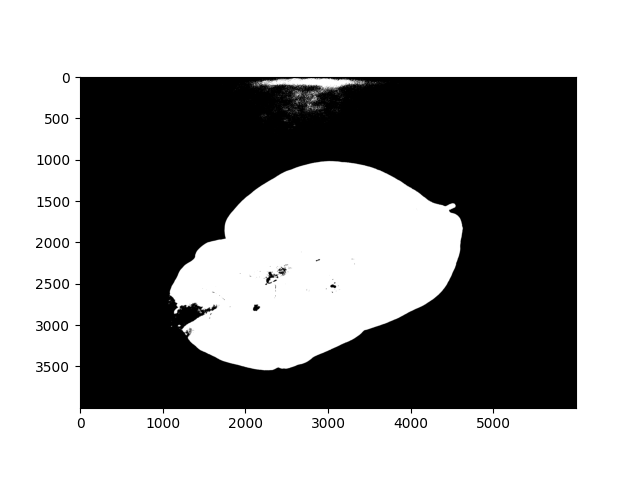

In [ ]:
# Create a binary mask with the threshold found by Otsu's method
binary_mask = blurred_image > t

fig, ax = plt.subplots()
ax.imshow(binary_mask, cmap='gray')

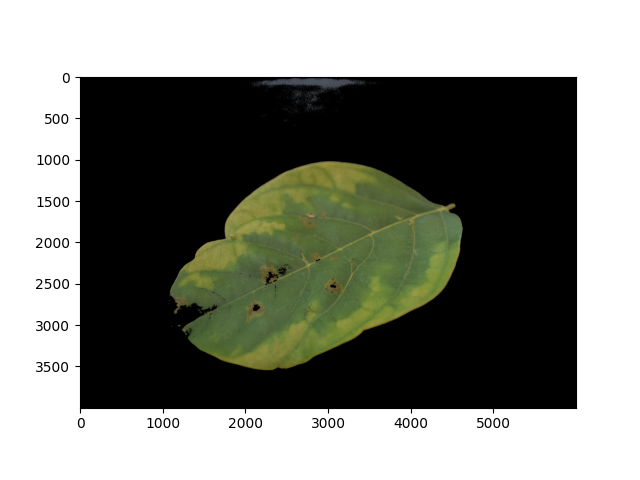

In [ ]:
# Apply the binary mask to the select the leaf
selection = leaf_det.copy()
selection[~binary_mask] = 0

fig, ax = plt.subplots()
ax.imshow(selection)

# Build function for pre-processing images

In [ ]:
# Image pre-processor
# Here I use Otsu's threshold method to eliminate as much of the background on each image

def clean_image(img_path):
    # Load image
    leaf_det = iio.imread(uri=img_path)
    # Convert the image to grayscale
    gray_image = ski.color.rgb2gray(leaf_det)
    # Blur the image to denoise
    blurred_image = ski.filters.gaussian(gray_image, sigma=1.0)
    # Perform automatic thresholding
    t = ski.filters.threshold_otsu(blurred_image)
    # Create a binary mask with the threshold found by Otsu's method
    binary_mask = blurred_image > t
    # Apply the binary mask to the select the leaf
    selection = leaf_det.copy()
    selection[~binary_mask] = 0
    # Save image
    newpath = "/content/drive/MyDrive/Datasets/leafdata/t_train/healthy/t_" + os.path.basename(img_path)
    iio.imwrite(uri=newpath, image=selection, extension=".jpg")



In [ ]:
# Single fiel call

clean_image('/content/0019_0065.JPG')

# Build folder iteration

In [ ]:
# Iterate through a directory

images = list()
for file in Path("/content/drive/MyDrive/Datasets/leafdata/train/healthy/").iterdir():
    if file.is_file():
        #images.append(print(file))
        clean_image(file)
        #print(file)
        #images.append(file)

# Support for third party widgets

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()